In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
from PIL import Image

import torch
from torch.autograd import Variable

import sys
sys.path.append('nets/')
from get_nets import PNet, RNet, ONet 

from important_parts import run_first_stage, nms, convert_to_square,\
    calibrate_box, preprocess, get_image_boxes
from utils import show_bboxes

# Load models

In [3]:
pnet = PNet()
rnet = RNet()
onet = ONet()
onet.eval();

# Set hyperparameters

In [4]:
# if this value is too low the algorithm could use a lot of memory
min_face_size = 15.0  

# for NMS
thresholds = [0.6, 0.7, 0.8]

# Load an image

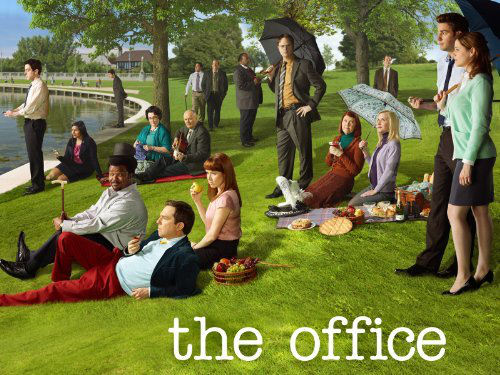

In [5]:
img = Image.open('images/office5.jpg')
img

# build an image pyramid

In [6]:
width, height = img.size
min_length = min(height, width)

min_detection_size = 12
factor = 0.707  # sqrt(0.5)

# scales for scaling the image
scales = []

# scales the image so that 
# minimum size that we can detect equals to
# minimum face size that we want to detect
m = min_detection_size/min_face_size
min_length *= m

factor_count = 0
while min_length > min_detection_size:
    scales.append(m*factor**factor_count)
    min_length *= factor
    factor_count += 1

print('number of different scales:', len(scales))

number of different scales: 10


# P-Net

In [7]:
bounding_boxes = []

# run P-Net on different scales
for s in scales:
    boxes = run_first_stage(img, pnet, s, thresholds[0])
    bounding_boxes.append(boxes)

bounding_boxes = [i for i in bounding_boxes if i is not None]
bounding_boxes = np.vstack(bounding_boxes)
print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 985


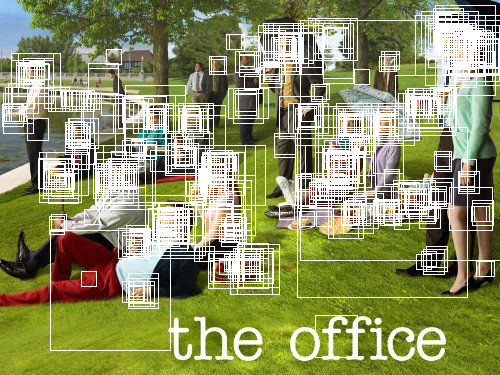

In [8]:
show_bboxes(img, bounding_boxes)

# NMS + calibration

In [9]:
pick = nms(bounding_boxes[:, 0:5], 0.7, 'union')
bounding_boxes = bounding_boxes[pick]
bounding_boxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
bounding_boxes = convert_to_square(bounding_boxes)
bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 597


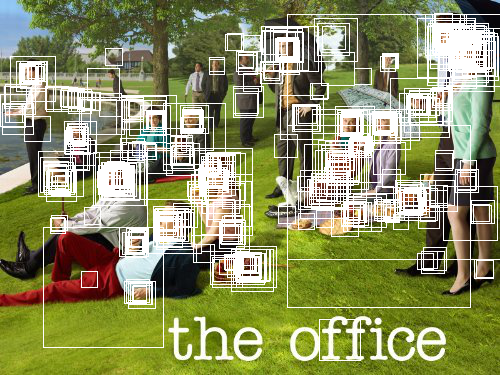

In [10]:
show_bboxes(img, bounding_boxes)

# R-Net

In [11]:
img_boxes = get_image_boxes(bounding_boxes, img, size=24)
img_boxes = Variable(torch.FloatTensor(img_boxes))
output = rnet(img_boxes)
offsets = output[0].data.numpy()
probs= output[1].data.numpy()

In [12]:
passed = np.where(probs[:, 1] > thresholds[1])
bounding_boxes = bounding_boxes[passed]

bounding_boxes[:, 4] = probs[passed, 1].reshape((-1,))
offsets = offsets[passed]

print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 156


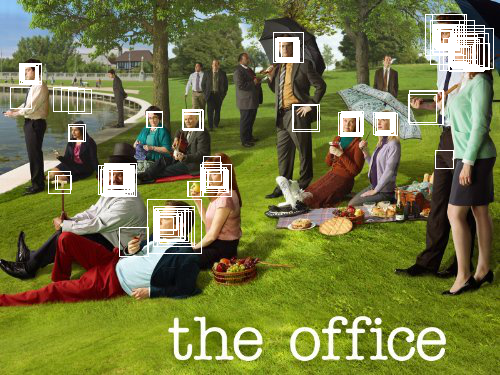

In [13]:
show_bboxes(img, bounding_boxes)

# NMS + calibration

In [14]:
pick = nms(bounding_boxes, 0.7, 'union')
bounding_boxes = bounding_boxes[pick]
bounding_boxes = calibrate_box(bounding_boxes, offsets[pick])
bounding_boxes = convert_to_square(bounding_boxes)
bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 77


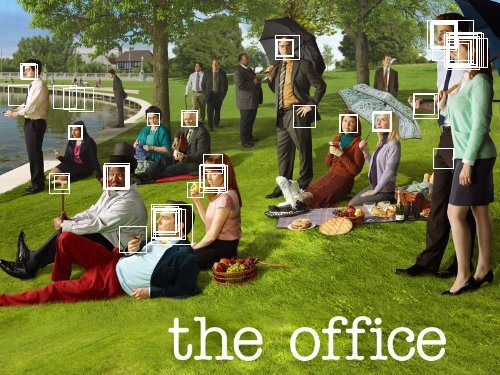

In [15]:
show_bboxes(img, bounding_boxes)

# O-Net

In [16]:
img_boxes = get_image_boxes(bounding_boxes, img, size=48)
img_boxes = Variable(torch.FloatTensor(img_boxes))
output = onet(img_boxes)
landmarks = output[0].data.numpy()
offsets = output[1].data.numpy()
probs = output[2].data.numpy()

In [17]:
passed = np.where(probs[:, 1] > thresholds[2])
bounding_boxes = bounding_boxes[passed]

bounding_boxes[:, 4] = probs[passed, 1].reshape((-1,))
offsets = offsets[passed]
landmarks = landmarks[passed]

# compute landmark points
bbw = bounding_boxes[:, 2] - bounding_boxes[:, 0] + 1.0
bbh = bounding_boxes[:, 3] - bounding_boxes[:, 1] + 1.0
landmarks[:, 0:5] = np.expand_dims(bounding_boxes[:, 0], 1) +\
    np.expand_dims(bbw, 1)*landmarks[:, 0:5]
landmarks[:, 5:10] = np.expand_dims(bounding_boxes[:, 1], 1) +\
    np.expand_dims(bbh, 1)*landmarks[:, 5:10]
    
print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 57


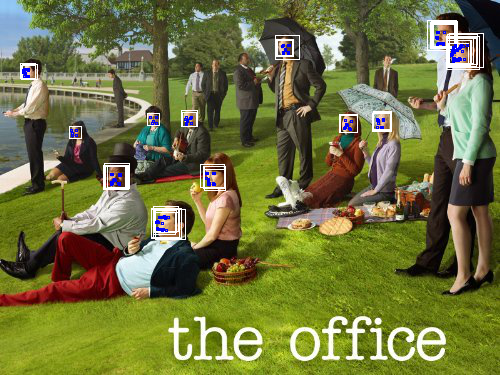

In [18]:
show_bboxes(img, bounding_boxes, landmarks)

# NMS + calibration

In [19]:
bounding_boxes = calibrate_box(bounding_boxes, offsets)
pick = nms(bounding_boxes, 0.7, 'min')
bounding_boxes = bounding_boxes[pick]
landmarks = landmarks[pick]
print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 12


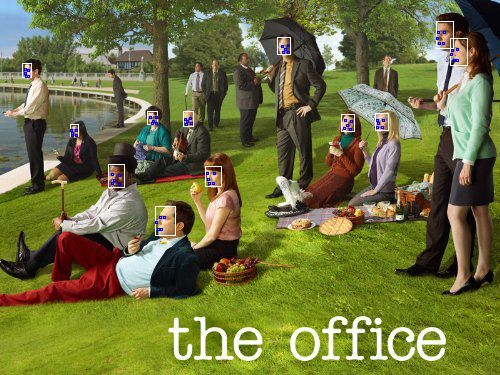

In [20]:
show_bboxes(img, bounding_boxes, landmarks)